# Proyecto 1 Analítica de textos

Integrantes:

- Maria Lucia Benavides Domínguez - 202313423 -> Líder de proyecto

- Yohan Felipe Gaitan Carvajal    - 202312115 -> Líder de datos & Líder de analítica

- Daniel Camilo Quimbay velasquez - 202313861 -> Líder de negocio

#### Link al repo: https://github.com/MxrixLu/Proyecto1_BI_Analitica_Textos
(Para acceeso rapido mientras tanto)

## Descripción del problema & objetivos

Este notebook se encuentra dividido en las siguientes secciones:

1. Importación de librerias necesarias
2. Carga de datos
3. Entendimiento de los datos
4. Procesamiento de texto, analisis exploratorio y DataFrame con TF-IDF
5. Division del dataset
6. Modelando con KNN
7. Random Forest
8. Regresión logistica
9. Comparacion de modelos
10. Interpretar el modelo con base en los objetivos de negocio

Problema:
El 25 de septiembre de 2015, la ONU adoptó la Agenda 2030 con sus 17 Objetivos de Desarrollo Sostenible (ODS). Para apoyar su cumplimiento, el UNFPA propone un proyecto que consiste en desarrollar un modelo analítico capaz de vincular automáticamente las opiniones ciudadanas con los ODS 1, 3 y 4. Este modelo se integrará en una aplicación web o móvil para clasificar textos de manera continua, con el fin de orientar políticas públicas informadas basadas en la participación ciudadana.



Diccionario:

textos = Cadenas de texto que representan las opiniones ciudadanas

labels = Valor numerico que representa la clasificación de los Objetivos de Desarrollo Sostenible luego solo puede ser 1,3 o 4

## 1. Importación de librerías

En las siguientes líneas de código se importan las librerías y herramientas necesarias para desarrollar el caso de uso.

In [ ]:
!python -m spacy download es_core_news_sm
!python -m spacy download es_core_news_lg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 88.7 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
import pandas as pd
# Para preparar los datos
from sklearn.preprocessing import LabelEncoder
# Para crear el arbol de decisión
from sklearn.tree import DecisionTreeClassifier
# Para usar KNN como clasificador
from sklearn.neighbors import KNeighborsClassifier
# Para realizar la separación del conjunto de aprendizaje en entrenamiento y test.
from sklearn.model_selection import train_test_split
# Para evaluar el modelo
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, accuracy_score

# Versiones anteriores a 1.2 de sklearn: from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# Para búsqueda de hiperparámetros
from sklearn.model_selection import GridSearchCV
# Para la validación cruzada
from sklearn.model_selection import KFold
#Librerías para la visualización
import matplotlib.pyplot as plt
# Seaborn
import seaborn as sns
from sklearn import tree
import sklearn as sklearn

#Para procesamiento de texto
import nltk
import string
from nltk.corpus import stopwords
from collections import Counter
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression


#Para training set
from sklearn.model_selection import train_test_split

#Para KNN
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, ConfusionMatrixDisplay

print('The scikit-learn version is {}.'.format(sklearn.__version__))

## 2. Carga de los datos
A través de la librería **pandas** podemos realizar la carga de datos desde diferentes fuentes de información, en este caso se realizará la carga de un archivo plano csv .

In [ ]:
# Se cargan los datos.

df = pd.read_excel('Datos_proyecto.xlsx')

In [ ]:
# Cantidad de datos y número de variables
df.shape

(2424, 2)

In [ ]:
# Mostrar los datos
df.head()

,textos,labels
0,"""Aprendizaje"" y ""educación"" se consideran sinó...",4
1,Para los niños más pequeños (bebés y niños peq...,4
2,"Además, la formación de especialistas en medic...",3
3,En los países de la OCDE se tiende a pasar de ...,4
4,Este grupo se centró en las personas que padec...,3


In [ ]:
# Podemos ver los tipos de todas la variables.
df.dtypes

,0
textos,object
labels,int64


## 3 Entendimiento de los datos

### 3.1 Perfilamiento de datos

Conteo por clase:
 labels
4    1025
3     894
1     505
Name: count, dtype: int64

Porcentaje por clase:
 labels
4    42.285479
3    36.881188
1    20.833333
Name: proportion, dtype: float64


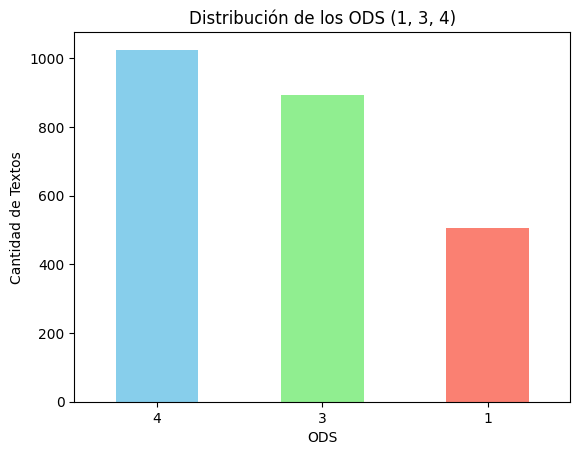

In [ ]:
distribution = df['labels'].value_counts()
print("Conteo por clase:\n", distribution)
print("\nPorcentaje por clase:\n", df['labels'].value_counts(normalize=True) * 100)

# Gráfico de barras
distribution.plot(kind='bar', color=['skyblue', 'lightgreen', 'salmon'])
plt.title('Distribución de los ODS (1, 3, 4)')
plt.xlabel('ODS')
plt.ylabel('Cantidad de Textos')
plt.xticks(rotation=0)
plt.show()

In [ ]:
# Calculamos longitud de cada opinión
df['textos_length'] = df['textos'].str.len()

# Estadísticas básicas sobre la longitud
textos_length_stats = df['textos_length'].describe()
print("\nEstadísticas básicas de longitud de descripción:")
print(textos_length_stats)


Estadísticas básicas de longitud de descripción:
count    2424.000000
mean      683.223185
std       223.563695
min       303.000000
25%       513.000000
50%       647.000000
75%       809.250000
max      1492.000000
Name: textos_length, dtype: float64


### 3.2 Análisis de calidad de datos

#### Completitud: Verificacion de valores nulos

In [ ]:
completitud_labels = 1 - (df['labels'].isnull().sum() / len(df))

print(f"Completitud de 'labels': {completitud_labels:.2%}")

Completitud de 'labels': 100.00%


In [ ]:
# Verifica nulos y strings vacíos/compuestos solo por espacios
textos_vacios = df['textos'].isnull() | (df['textos'].str.strip().str.len() == 0)
textos_empty =  (df['textos'].str.strip() == '')
completitud_textos = 1 - (textos_vacios.sum() + textos_vacios.sum() / len(df))

print(f"Completitud de 'textos': {completitud_textos:.2%}")

Completitud de 'textos': 100.00%


#### Unicidad: revisar filas duplicadas completas y duplicados parciales

In [ ]:
# Busca duplicados exactos en todas las columnas
duplicados_exactos = df.duplicated().sum()
print(f"Registros duplicados (exactos): {duplicados_exactos} ({duplicados_exactos/len(df):.2%})")

# Busca duplicados solo en la columna 'textos' (pueden tener etiquetas diferentes, lo cual es un problema de consistencia)
duplicados_textos = df.duplicated(subset=['textos']).sum()
print(f"Textos duplicados (pueden tener distinto label): {duplicados_textos}")

Registros duplicados (exactos): 0 (0.00%)
Textos duplicados (pueden tener distinto label): 0


#### Validez: Verificación de formatos

##### Para 'labels'

In [ ]:
valores_Validos = {1, 3, 4}
valores_Invalidos = ~df['labels'].isin(valores_Validos)
# Asegurémonos de manejar nulos primero para no contarlos como inválidos aquí
validez_labels = 1 - (valores_Invalidos.sum() / len(df))
print(f"Validez de 'labels': {validez_labels:.2%}")
print(f"Valores inválidos encontrados: {df[valores_Invalidos]['labels'].unique()}")

Validez de 'labels': 100.00%
Valores inválidos encontrados: []


##### Para 'textos'


In [ ]:
longitud_minima_valida = 2 # Define un umbral
textos_validos = df['textos'].str.split().str.len() > longitud_minima_valida
validez_textos = (textos_validos.sum() / len(df))
print(f"Validez de 'textos' (> {longitud_minima_valida} palabras): {validez_textos:.2%}")

Validez de 'textos' (> 2 palabras): 100.00%


#### Consistencia: Valores atipicos

¿El mismo texto textos aparece con diferentes labels?

In [ ]:
# Agrupa por texto y cuenta los valores únicos de la etiqueta
grupo_textos = df.groupby('textos')['labels'].agg(['nunique', 'count']).sort_values(by='nunique', ascending=False)
textos_inconsistentes = grupo_textos[grupo_textos['nunique'] > 1]
print(f"Número de textos con etiquetas inconsistentes: {len(textos_inconsistentes)}")
# Muestra algunos ejemplos
if not textos_inconsistentes.empty:
    texto_ejemplo = textos_inconsistentes.index[0]
    print(f"\nEjemplo de inconsistencia para el texto: '{texto_ejemplo}'")
    print(f"Tiene estas etiquetas asignadas: {df[df['textos'] == texto_ejemplo]['labels'].unique()}")

Número de textos con etiquetas inconsistentes: 0


## 4. Procesamiento de texto: tokenización y limpieza de palabras

#### Objetivos:

- Tokenizar las opiniones: separar cada texto en palabras individuales.  
- Limpiar el texto: pasar a minúsculas, eliminar signos de puntuación y palabras vacías (stopwords).  
- Crear un dataframe con las palabras procesadas para análisis posteriores.

#### Desarrollo:

1. Descargar y definir las stopwords en español o inglés según el dataset.  
2. Definir función para limpiar y tokenizar el texto.  
3. Aplicar la función a la columna "textos" y almacenar el resultado en una nueva columna.  
4. Crear un dataframe de palabras tokenizadas para análisis posterior.

In [ ]:
import spacy
from spacy.lang.es.stop_words import STOP_WORDS

# Cargar modelo de spaCy para español
nlp = spacy.load("es_core_news_sm")

# Ampliar stopwords con palabras poco útiles para nuestro dominio
custom_stopwords = STOP_WORDS.union({"colombia", "personas", "importante"})

# Función para limpiar, tokenizar y lematizar
def clean_tokenize_spacy(text):
    if pd.isnull(text):
        return []
    doc = nlp(text.lower())
    tokens = [
        token.lemma_ for token in doc
        if not token.is_punct
        and not token.is_space
        and token.lemma_ not in custom_stopwords
    ]
    return tokens

# Aplicar tokenización y lematización
df['tokens'] = df['textos'].apply(clean_tokenize_spacy)

# Crear columna con texto limpio para TF-IDF
df['clean_text'] = df['tokens'].apply(lambda tokens: " ".join(tokens))

print("Ejemplos de tokens lematizados con spaCy:")
display(df[['textos', 'tokens']].head())

Ejemplos de tokens lematizados con spaCy:


,textos,tokens
0,"""Aprendizaje"" y ""educación"" se consideran sinó...","[aprendizaje, educación, considerar, sinónir, ..."
1,Para los niños más pequeños (bebés y niños peq...,"[niño, pequeño, bebé, niño, pequeño, capacitac..."
2,"Además, la formación de especialistas en medic...","[formación, especialista, medicina, general, i..."
3,En los países de la OCDE se tiende a pasar de ...,"[país, ocde, tender, pasar, curso, obligatorio..."
4,Este grupo se centró en las personas que padec...,"[grupo, centrar, persona, padecer, trastorno, ..."


### 4.1 Análisis exploratorio de palabras más frecuentes y representativas

En esta sección exploraremos las palabras extraídas en la tokenización y limpieza de la 'textos'.
Nuestro objetivo es identificar las palabras que aparecen con mayor frecuencia y que mejor
describen el conjunto de opiniones.

#### Objetivos:

- Calcular la frecuencia de aparición de cada palabra en todas las opiniones.  
- Visualizar las palabras más frecuentes mediante tablas y gráficos.  
- Analizar la relevancia de las palabras para entender el vocabulario característico del dataset.

#### Desarrollo:

1. Aplanar la lista de tokens en una sola lista.  
2. Contar la frecuencia de cada palabra usando `Counter` de la librería `collections`.  
3. Mostrar las 20 palabras más comunes en una tabla.  
4. Graficar con una barra las palabras más frecuentes.

Las 20 palabras más frecuentes en las descripciones con su IDF:


,Word,Frequency,IDF
0,país,1146,1.196029
1,salud,1109,1.524078
2,pobreza,1019,1.806722
3,educación,992,1.492389
4,escuela,913,1.697350
5,atención,900,1.672877
6,estudiante,778,1.769727
7,nivel,730,1.496065
8,año,717,1.670682
9,sistema,713,1.560726


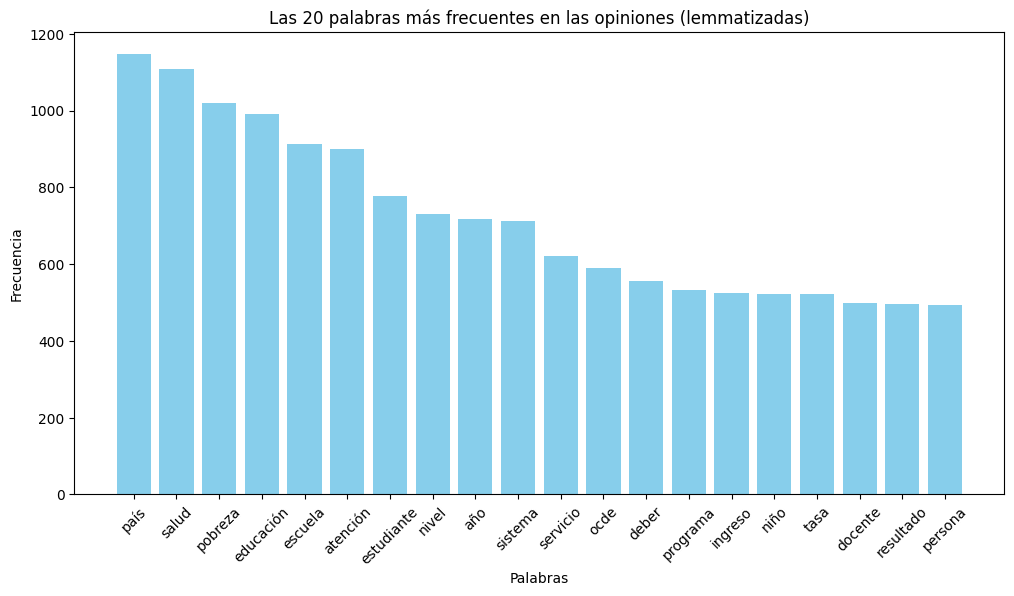

In [ ]:
N = len(df)

# Aplanar la lista de tokens
all_tokens = [token for tokens_list in df['tokens'] for token in tokens_list]

# Contar frecuencia de palabras
word_counts = Counter(all_tokens)

most_common_words = word_counts.most_common(20)

# Calcular IDF para cada palabra
df_counts = {word: sum(word in tokens for tokens in df['tokens']) for word, _ in most_common_words}
idf_scores = {word: np.log(N / (df_counts[word] if df_counts[word] > 0 else 1)) for word in df_counts}

# Construir dataframe
freq_idf_data = [{"Word": word, "Frequency": freq, "IDF": idf_scores[word]} for word, freq in most_common_words]
freq_df = pd.DataFrame(freq_idf_data)

print("Las 20 palabras más frecuentes en las descripciones con su IDF:")
display(freq_df)

# Graficar
plt.figure(figsize=(12,6))
plt.bar(freq_df['Word'], freq_df['Frequency'], color='skyblue')
plt.xticks(rotation=45)
plt.title('Las 20 palabras más frecuentes en las opiniones (lemmatizadas)')
plt.xlabel('Palabras')
plt.ylabel('Frecuencia')
plt.show()


## 4.2 Creación del DataFrame con TF-IDF de palabras representativas y variable objetivo

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Definir vectorizador TF-IDF con más features y bigramas
vectorizer = TfidfVectorizer(
    max_features=1000,
    min_df=5,
    ngram_range=(1,2)  # unigrams y bigrams
)

# Aplicar TF-IDF sobre la columna 'clean_text' (ya tokenizada + lematizada)
tfidf_matrix = vectorizer.fit_transform(df['clean_text'].fillna(""))

# Convertir a DataFrame
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())

# Unir con etiquetas
final_df = pd.concat([df[['labels']], tfidf_df], axis=1)

print("Primeras filas del DataFrame final con TF-IDF y variable objetivo:")
display(final_df.head())


Primeras filas del DataFrame final con TF-IDF y variable objetivo:


,labels,000,10,100,11,12,13,14,15,15 año,...,zelanda,zona,zona rural,ámbito,área,él,éxito,índice,único,útil
0,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
1,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
2,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
3,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.242287,0.0,0.0,0.0,0.0
4,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.168961,0.0,0.000000,0.0,0.0,0.0,0.0


## 5. División de dataset

In [ ]:
# Definimos X e y para todos los modelos
X = final_df.drop('labels', axis=1)
y = final_df['labels']

# Dividir en train y test
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

print("Tamaño entrenamiento:", X_train.shape)
print("Tamaño prueba:", X_test.shape)
print("Distribución de clases en train:", y_train.value_counts(normalize=True))
print("Distribución de clases en test:", y_test.value_counts(normalize=True))

Tamaño entrenamiento: (1696, 1000)
Tamaño prueba: (728, 1000)
Distribución de clases en train: labels
4    0.422759
3    0.369104
1    0.208137
Name: proportion, dtype: float64
Distribución de clases en test: labels
4    0.423077
3    0.368132
1    0.208791
Name: proportion, dtype: float64


## 6.KNN

In [ ]:
# Instanciamos el modelo KNN con 5 vecinos
knn = KNeighborsClassifier(n_neighbors=5)

# Entrenamos el modelo usando los datos de entrenamiento
knn.fit(X_train, y_train)

print("El modelo KNN se ha entrenado correctamente!")

El modelo KNN se ha entrenado correctamente!


### Evaluando el modelo

Matriz de confusión:


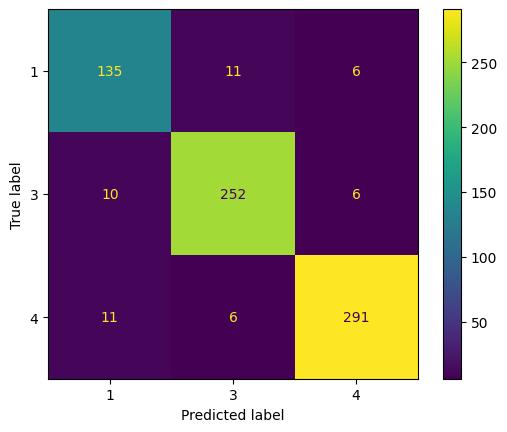


Reporte de clasificación:
              precision    recall  f1-score   support

           1       0.87      0.89      0.88       152
           3       0.94      0.94      0.94       268
           4       0.96      0.94      0.95       308

    accuracy                           0.93       728
   macro avg       0.92      0.92      0.92       728
weighted avg       0.93      0.93      0.93       728


Accuracy Score:
0.9313186813186813


In [ ]:
# Hacemos las prediciones en el conjunto de prueba
y_pred = knn.predict(X_test)

# Evaluamos el modelo
print("Matriz de confusión:")
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn.classes_)
disp.plot()
plt.show()


print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred))

print("\nAccuracy Score:")
print(accuracy_score(y_test, y_pred))

### Hyperparametros

In [ ]:
# Definimos el rango para el parameter grid
param_grid = {'n_neighbors': range(1, 31)}

# Instanciamos el GridSearchCV
grid_search = GridSearchCV(
    estimator=KNeighborsClassifier(),
    param_grid=param_grid,
    cv=5,  # Using 5-fold cross-validation
    scoring='accuracy' # Usamos la precisión como la metrica de score
)

# Le pasamos los datos de entrenamiento al GridSearch
grid_search.fit(X_train, y_train)

# Imprimimos los mejores parametros y los mejores scores
print("Mejores parámetros encontrados:", grid_search.best_params_)
print("Mejor puntuación de validación cruzada:", grid_search.best_score_)

# Guardamos el mejor modelo para una estimación final
best_knn_model = grid_search.best_estimator_

Mejores parámetros encontrados: {'n_neighbors': 24}
Mejor puntuación de validación cruzada: 0.9705153565851118


### Evaluando el mejor modelo encontrado

Matriz de confusión (Mejor modelo KNN):


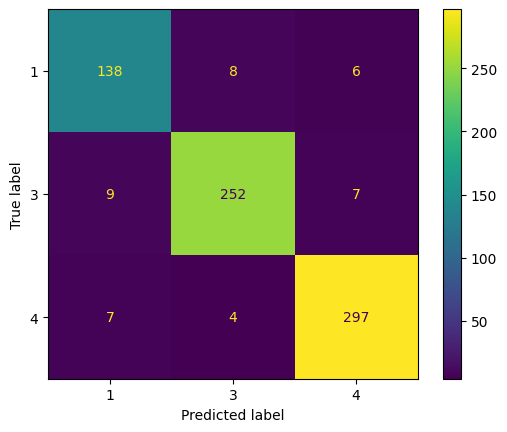


Reporte de clasificación (Mejor modelo KNN):
              precision    recall  f1-score   support

           1       0.90      0.91      0.90       152
           3       0.95      0.94      0.95       268
           4       0.96      0.96      0.96       308

    accuracy                           0.94       728
   macro avg       0.94      0.94      0.94       728
weighted avg       0.94      0.94      0.94       728


Accuracy Score (Best KNN Model):
0.9436813186813187


In [ ]:
# Utilizamos el mejor modelo encontrado en la sección anterior y hacemos las predicciones en el set de testeo
y_pred_best = best_knn_model.predict(X_test)

# Evaluamos el mejor modelo
print("Matriz de confusión (Mejor modelo KNN):")
cm_best = confusion_matrix(y_test, y_pred_best)
disp_best = ConfusionMatrixDisplay(confusion_matrix=cm_best, display_labels=best_knn_model.classes_)
disp_best.plot()
plt.show()

print("\nReporte de clasificación (Mejor modelo KNN):")
print(classification_report(y_test, y_pred_best))

print("\nAccuracy Score (Best KNN Model):")
print(accuracy_score(y_test, y_pred_best))

## 7. Random Forest

Reporte de Clasificación:

              precision    recall  f1-score   support

           1       0.92      0.93      0.93       152
           3       0.97      0.96      0.96       268
           4       0.97      0.98      0.98       308

    accuracy                           0.96       728
   macro avg       0.95      0.96      0.95       728
weighted avg       0.96      0.96      0.96       728



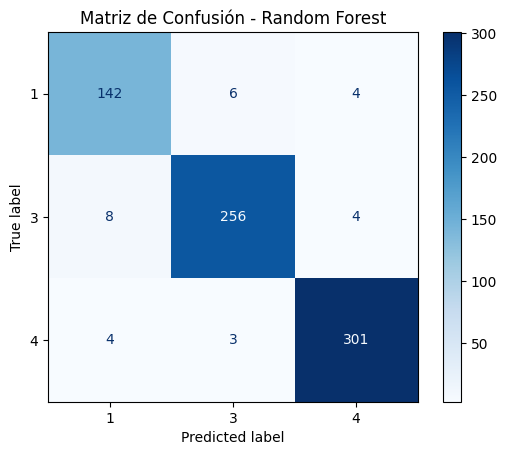

Exactitud del modelo: 0.9602


In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Crear el modelo de Random Forest
rf = RandomForestClassifier(
    n_estimators=500,   # número de árboles
    min_samples_split=10,  # mínimo de muestras para dividir un nodo
    min_samples_leaf=2,     # mínimo de muestras en una hoja,
    max_features='log2',   # número de características a considerar al dividir
    max_depth=30, # profundidad máxima (None = expandir hasta hojas puras),
    class_weight='balanced',  # balancear las clases
    random_state=42,
    n_jobs=-1           # usar todos los núcleos para entrenar más rápido
)

# Entrenar el modelo
rf.fit(X_train, y_train)

# Predicciones
y_pred = rf.predict(X_test)

# Evaluación del modelo
print("Reporte de Clasificación:\n")
print(classification_report(y_test, y_pred))

# Matriz de confusión
ConfusionMatrixDisplay.from_estimator(rf, X_test, y_test, cmap="Blues")
plt.title("Matriz de Confusión - Random Forest")
plt.show()

# Precisión global
accuracy = accuracy_score(y_test, y_pred)
print(f"Exactitud del modelo: {accuracy:.4f}")


## 8. Naive Bayes

### Prueba con diferentes tipos de Naive Bayes

In [ ]:
from sklearn.naive_bayes import MultinomialNB, GaussianNB, ComplementNB
from sklearn.model_selection import  cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

naive_bayes_models={}
results = {}

#------- Multinomial NaiveBayes -------

mnb = MultinomialNB()
mnb.fit(X_train, y_train)
mnb_pred = mnb.predict(X_test)
naive_bayes_models['Multinomial'] = mnb

results['Multinomial'] = {
    'accuracy': accuracy_score(y_test, mnb_pred),
    'f1_macro': f1_score(y_test, mnb_pred, average='macro'),
    'f1_weighted': f1_score(y_test, mnb_pred, average='weighted'),
    'predictions': mnb_pred
}


print(f"Accuracy: {results['Multinomial']['accuracy']:.4f}")
print(f"F1-score (macro): {results['Multinomial']['f1_macro']:.4f}")
print(f"F1-score (weighted): {results['Multinomial']['f1_weighted']:.4f}")

#------ Complement Naive Bayes -------
cnb = ComplementNB()
cnb.fit(X_train, y_train)
cnb_pred = cnb.predict(X_test)
naive_bayes_models['Complement'] = cnb

results['Complement'] = {
    'accuracy': accuracy_score(y_test, cnb_pred),
    'f1_macro': f1_score(y_test, cnb_pred, average='macro'),
    'f1_weighted': f1_score(y_test, cnb_pred, average='weighted'),
    'predictions': cnb_pred
}


print(f"Accuracy: {results['Complement']['accuracy']:.4f}")
print(f"F1-score (macro): {results['Complement']['f1_macro']:.4f}")
print(f"F1-score (weighted): {results['Complement']['f1_weighted']:.4f}")



#-------- Gaussian Naive Bayes

gnb = GaussianNB()
gnb.fit(X_train, y_train)
gnb_pred = gnb.predict(X_test)
naive_bayes_models['Gaussian'] = gnb

results['Gaussian'] = {
    'accuracy': accuracy_score(y_test, gnb_pred),
    'f1_macro': f1_score(y_test, gnb_pred, average='macro'),
    'f1_weighted': f1_score(y_test, gnb_pred, average='weighted'),
    'predictions': gnb_pred
}


print(f"Accuracy: {results['Gaussian']['accuracy']:.4f}")
print(f"F1-score (macro): {results['Gaussian']['f1_macro']:.4f}")
print(f"F1-score (weighted): {results['Gaussian']['f1_weighted']:.4f}")


Accuracy: 0.9423
F1-score (macro): 0.9353
F1-score (weighted): 0.9419
Accuracy: 0.9588
F1-score (macro): 0.9547
F1-score (weighted): 0.9588
Accuracy: 0.9080
F1-score (macro): 0.8975
F1-score (weighted): 0.9074


### Selección del mejor modelo entre los 3

In [ ]:
comparison_df = pd.DataFrame(results).T
print("\nComparación de modelos Naive Bayes:")
print(comparison_df[['accuracy', 'f1_macro', 'f1_weighted']])

# Seleccionar el mejor modelo basado en F1-score macro
best_model_name = comparison_df['f1_macro'].idxmax()
best_model = naive_bayes_models[best_model_name]

print(f"\nMejor modelo: {best_model_name} Naive Bayes")
print(f"F1-score macro: {results[best_model_name]['f1_macro']:.4f}")


Comparación de modelos Naive Bayes:
             accuracy  f1_macro f1_weighted
Multinomial  0.942308  0.935295    0.941929
Complement   0.958791  0.954745    0.958782
Gaussian     0.907967   0.89754    0.907427

Mejor modelo: Complement Naive Bayes
F1-score macro: 0.9547


### Optimización de Hiperparametros con el mejor modelo (Complement Naive Bayes)

In [ ]:
param_grid = {
        'alpha': [0.01, 0.1, 0.5, 1.0, 2.0, 5.0],
        'fit_prior': [True, False],
        'norm': [True, False]
    }
model_for_grid = ComplementNB()


grid_search = GridSearchCV(
    model_for_grid,
    param_grid,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

print(f"Mejores hiperparámetros: {grid_search.best_params_}")
print(f"Mejor F1-score (CV): {grid_search.best_score_:.4f}")

best_optimized_model = grid_search.best_estimator_

final_predictions = best_optimized_model.predict(X_test)


final_accuracy = accuracy_score(y_test, final_predictions)
final_f1_macro = f1_score(y_test, final_predictions, average='macro')
final_f1_weighted = f1_score(y_test, final_predictions, average='weighted')

print(f"Accuracy final: {final_accuracy:.4f}")
print(f"F1-score macro final: {final_f1_macro:.4f}")
print(f"F1-score weighted final: {final_f1_weighted:.4f}")

# Reporte de clasificación detallado
print("\n--- Reporte de Clasificación ---")
target_names = [f'ODS_{label}' for label in sorted(y.unique())]
print(classification_report(y_test, final_predictions, target_names=target_names))


Fitting 5 folds for each of 24 candidates, totalling 120 fits
Mejores hiperparámetros: {'alpha': 5.0, 'fit_prior': True, 'norm': True}
Mejor F1-score (CV): 0.9751
Accuracy final: 0.9574
F1-score macro final: 0.9526
F1-score weighted final: 0.9574

--- Reporte de Clasificación ---
              precision    recall  f1-score   support

       ODS_1       0.92      0.93      0.93       152
       ODS_3       0.98      0.94      0.96       268
       ODS_4       0.96      0.98      0.97       308

    accuracy                           0.96       728
   macro avg       0.95      0.95      0.95       728
weighted avg       0.96      0.96      0.96       728



### Visualización

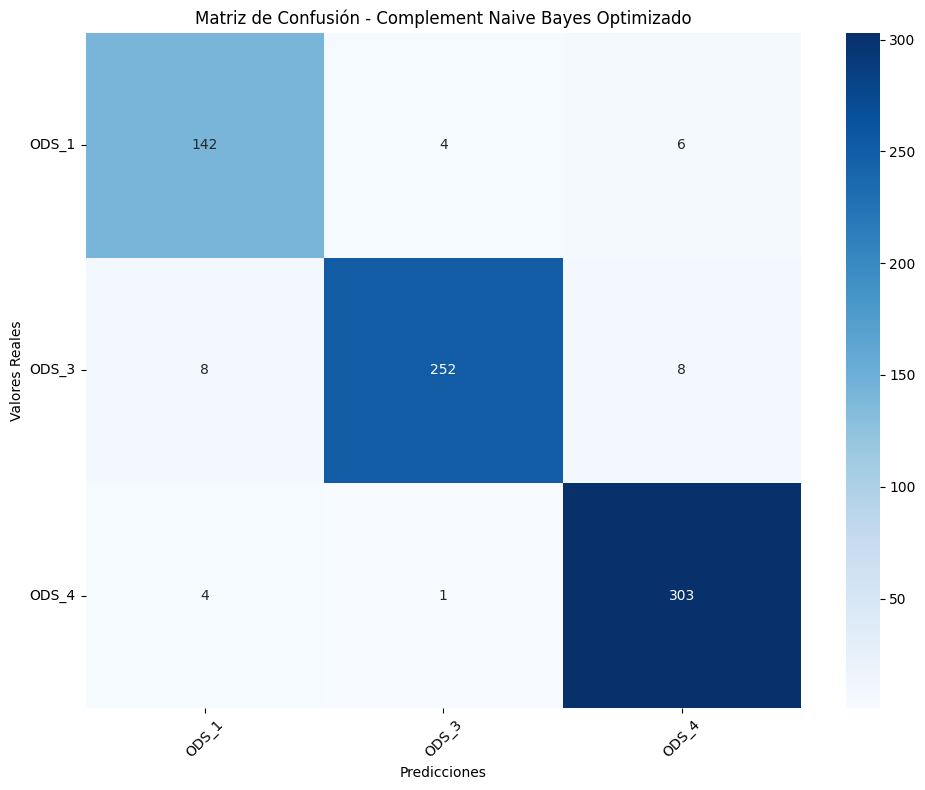

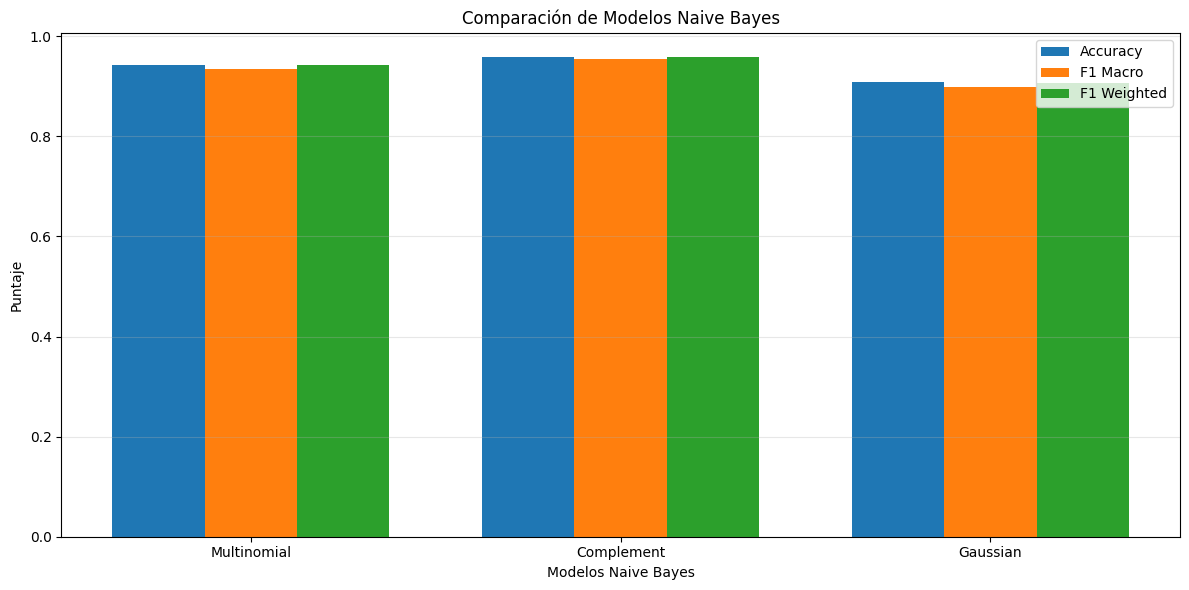

In [ ]:
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, final_predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)
plt.title(f'Matriz de Confusión - {best_model_name} Naive Bayes Optimizado')
plt.xlabel('Predicciones')
plt.ylabel('Valores Reales')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# 6.2 Comparación de modelos
plt.figure(figsize=(12, 6))
models = list(results.keys())
metrics = ['accuracy', 'f1_macro', 'f1_weighted']

x = np.arange(len(models))
width = 0.25

for i, metric in enumerate(metrics):
    values = [results[model][metric] for model in models]
    plt.bar(x + i*width, values, width, label=metric.replace('_', ' ').title())

plt.xlabel('Modelos Naive Bayes')
plt.ylabel('Puntaje')
plt.title('Comparación de Modelos Naive Bayes')
plt.xticks(x + width, models)
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()



## Cuarto modelo usando word embeddings

In [ ]:
nlp_embeddings = spacy.load("es_core_news_lg")

if nlp_embeddings:
    # Función para obtener el vector de un texto (promedio de vectores de tokens)
    def get_text_vector(text):
        if pd.isnull(text):
            return np.zeros(nlp_embeddings.vocab.vectors.shape[1]) # Return zero vector for empty text
        doc = nlp_embeddings(text)
        # Filtramos tokens sin vector (ej: puntuación, espacios)
        valid_tokens = [token for token in doc if token.has_vector and token.vector_norm > 0]
        if not valid_tokens:
            return np.zeros(nlp_embeddings.vocab.vectors.shape[1])
        # Promedio de vectores de tokens válidos
        return np.mean([token.vector for token in valid_tokens], axis=0)

    # Aplicar la función para obtener los vectores de cada texto
    df['text_vector'] = df['clean_text'].apply(get_text_vector)

    # Crear DataFrame con los vectores y las etiquetas
    X_embeddings = np.vstack(df['text_vector'].values)
    y_embeddings = df['labels']

    # Convertir a DataFrame de pandas para consistencia con modelos anteriores
    X_embeddings_df = pd.DataFrame(X_embeddings)
    y_embeddings_df = pd.DataFrame(y_embeddings)

    print("DataFrame con word embeddings y variable objetivo creado:")
    display(pd.concat([y_embeddings_df, X_embeddings_df], axis=1).head())

else:
    print("No se pudo cargar un modelo de spaCy con embeddings. No se generará el DataFrame de embeddings.")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 568.0/568.0 MB 1.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
DataFrame con word embeddings y variable objetivo creado:


,labels,0,1,2,3,4,5,6,7,8,...,290,291,292,293,294,295,296,297,298,299
0,4,0.319665,1.007201,0.781353,-0.965007,0.827064,-0.746066,-1.419562,0.895101,-0.350940,...,-0.138030,0.628481,-1.039321,0.868535,0.635549,-0.161437,-0.152492,0.495939,-0.266061,-1.876391
1,4,0.185571,0.693821,-0.421002,-0.300417,0.779107,-0.407324,-1.607101,0.832222,-0.244256,...,0.005287,0.659237,-0.841103,-0.057123,0.752674,-1.189100,-0.152044,-0.132051,-0.373045,-1.492484
2,3,0.281763,0.624087,0.028429,-1.283780,0.529018,-0.204670,-1.496755,0.836134,-1.204977,...,0.178756,1.449559,-0.882228,0.080391,0.650239,-1.268152,-0.304199,-0.013958,-0.429659,-1.532390
3,4,0.013067,0.901790,-0.116804,-0.300375,0.809410,-0.139390,-2.177692,1.004311,0.104949,...,0.946132,-0.026669,-0.251131,-0.196344,0.688739,-1.128652,-0.012253,-0.068982,0.141139,-1.640577
4,3,0.702592,0.731741,0.202120,-1.395560,0.560317,0.087610,-1.517543,0.412396,-1.057813,...,0.406055,1.207049,-0.977379,0.873519,0.880091,-1.371305,-0.277632,-0.274353,0.184199,-1.672792


#### Logistic Regression

Reporte de Clasificación (Regresión Logística con Embeddings):
              precision    recall  f1-score   support

           1       0.93      0.89      0.91       152
           3       0.95      0.96      0.95       268
           4       0.96      0.97      0.97       308

    accuracy                           0.95       728
   macro avg       0.95      0.94      0.94       728
weighted avg       0.95      0.95      0.95       728



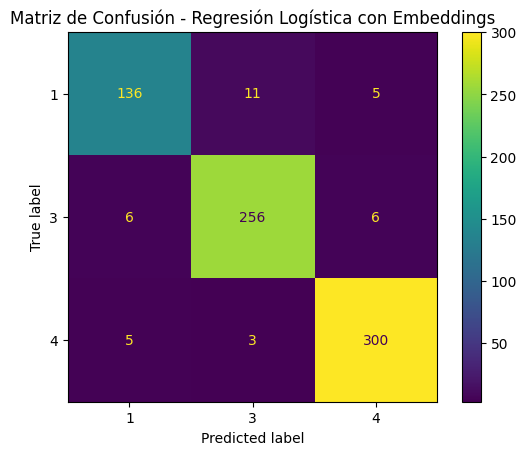


Exactitud del modelo (Regresión Logística con Embeddings): 0.9505


In [35]:
if 'X_embeddings_df' in locals() and 'y_embeddings' in locals():
    # Dividir los datos en conjuntos de entrenamiento y prueba
    X_train_emb, X_test_emb, y_train_emb, y_test_emb = train_test_split(
        X_embeddings_df,
        y_embeddings,
        test_size=0.3,
        random_state=42,
        stratify=y_embeddings
    )

    # Inicializar y entrenar el modelo de Regresión Logística
    log_reg_model = LogisticRegression(max_iter=1000, random_state=42) # Aumentar max_iter por si no converge
    log_reg_model.fit(X_train_emb, y_train_emb)

    # Realizar predicciones
    y_pred_emb = log_reg_model.predict(X_test_emb)

    # Evaluar el modelo
    print("Reporte de Clasificación (Regresión Logística con Embeddings):")
    print(classification_report(y_test_emb, y_pred_emb))

    # Matriz de confusión
    cm_emb = confusion_matrix(y_test_emb, y_pred_emb)
    disp_emb = ConfusionMatrixDisplay(confusion_matrix=cm_emb, display_labels=log_reg_model.classes_)
    disp_emb.plot()
    plt.title("Matriz de Confusión - Regresión Logística con Embeddings")
    plt.show()

    # Exactitud global
    accuracy_emb = accuracy_score(y_test_emb, y_pred_emb)
    print(f"\nExactitud del modelo (Regresión Logística con Embeddings): {accuracy_emb:.4f}")

else:
    print("Los DataFrames de embeddings no se crearon correctamente. Asegúrate de que el modelo spaCy se cargó.")

## Usando el mejor modelo con los datos de prueba

#### Dado que random forest obtuvo el mejor accuracy score sobre todos los modelos usamos este

In [37]:
# Load the test data
df_test = pd.read_excel('Datos de prueba_proyecto.xlsx')

# Apply the same cleaning and tokenization as before
df_test['tokens'] = df_test['Textos_espanol'].apply(clean_tokenize_spacy)
df_test['clean_text'] = df_test['tokens'].apply(lambda tokens: " ".join(tokens))

# Apply the same TF-IDF vectorization
# Use the same vectorizer fitted on the training data
tfidf_matrix_test = vectorizer.transform(df_test['clean_text'].fillna(""))
X_test_processed = pd.DataFrame(tfidf_matrix_test.toarray(), columns=vectorizer.get_feature_names_out())

# Use the best Random Forest model to predict the labels
# Assuming 'rf' is the best Random Forest model from the previous steps
df_test['predicted_labels'] = rf.predict(X_test_processed)

# Drop the intermediate columns
df_test = df_test.drop(columns=['tokens', 'clean_text'])

print("Test data with predicted labels:")
display(df_test.head())

# Save the DataFrame with predicted labels to a new Excel file
output_filename = 'Datos_prueba_con_predicciones.xlsx'
df_test.to_excel(output_filename, index=False)
print(f"\nDataFrame con predicciones guardado en '{output_filename}'")

Test data with predicted labels:


,Textos_espanol,predicted_labels
0,"El rector, que es el representante local del M...",4
1,Tenga en cuenta que todos los programas antipo...,3
2,"Debido a que son en gran medida invisibles, es...",1
3,Los recursos aún son limitados en este sector....,3
4,"Durante el período 1985-2008, la educación pri...",4



DataFrame con predicciones guardado en 'Datos_prueba_con_predicciones.xlsx'
